In [4]:
%matplotlib notebook
import json
import numpy as np
import os
import pandas as pd
import sys
import matplotlib.pyplot as plt

if sys.version_info[0] == 3:
    from urllib.request import urlopen
else:
    # Not Python 3 - today, it is most likely to be Python 2
    # But note that this might need an update when Python 4
    # might be around one day
    from urllib import urlopen


In [2]:
# connect to poloniex's API
CURRENCIES = ['USDT_BTC', 'USDT_LTC', 'USDT_ETH', 'USDT_XRP']
url = 'https://poloniex.com/public?command=returnChartData&currencyPair=$C&start=1356998100&end=9999999999&period=300'
urls = [url.replace('$C', c) for c in CURRENCIES]

for i, c in enumerate(CURRENCIES):
    with urlopen(urls[i]) as url:
        r = url.read()
        d = json.loads(r.decode())
        df = pd.DataFrame(d)
        df = df.drop(columns=['high', 'low', 'open'])
        #print(df.columns)
        df.to_pickle('data/poloniex/' + c + '.pkl')
        print('Successfully downloaded', c)

Successfully downloaded USDT_BTC
Successfully downloaded USDT_LTC
Successfully downloaded USDT_ETH
Successfully downloaded USDT_XRP


In [5]:
data_df = pd.read_pickle('data/poloniex/combined.pkl')
#btc_df = pd.read_pickle('data/coinmarketcap/bitcoin.pkl')
print(data_df.columns)
class PastSampler:

    def __init__(self, N, K, sliding_window = True):
        self.K = K
        self.N = N
        self.sliding_window = sliding_window
 
    def transform(self, A):
        M = self.N + self.K     #Number of samples per row (sample + target)
        #indexes
        if self.sliding_window:
            I = np.arange(M) + np.arange(A.shape[0] - M + 1).reshape(-1, 1)
        else:
            if A.shape[0]%M == 0:
                I = np.arange(M)+np.arange(0,A.shape[0],M).reshape(-1,1)
                
            else:
                I = np.arange(M)+np.arange(0,A.shape[0] -M,M).reshape(-1,1)
            
        print(I)
        print(I.shape)
        
        B = A[I].reshape(-1, M * A.shape[1], A.shape[2])
        ci = self.N * A.shape[1]    #Number of features per sample
        return B[:, :ci], B[:, ci:] #Sample matrix, Target matrix

Index(['btc_close', 'btc_quoteVolume', 'btc_volume', 'eth_close',
       'eth_quoteVolume', 'eth_volume', 'ltc_close', 'ltc_quoteVolume',
       'ltc_volume', 'xrp_close', 'xrp_quoteVolume', 'xrp_volume', 'date'],
      dtype='object')


In [20]:
#poloniex
data_df.head()
data_df = data_df.drop(columns=['date'])

#btc_df.head()
#btc_df = btc_df.drop(columns=['time', 'time_readable', 'price_btc', 'market_cap']).query('volume_usd>0')
#btc_df.head()

In [6]:
import sklearn.preprocessing as prep
scaler = prep.MinMaxScaler()
original_A = np.array(data_df)[:,None,:]
A = np.array(scaler.fit_transform(data_df))[:,None,:]
print(data_df.shape)
print(original_A.shape)
print(A.shape)

(280053, 13)
(280053, 1, 13)
(280053, 1, 13)


In [7]:
NPS, NFS = 256, 32         #Number of past and future samples
ps = PastSampler(NPS, NFS, sliding_window=True)
datas, labels = ps.transform(A)
print(datas.shape, labels.shape)

labels = labels[:,:,0].reshape(-1, NFS, 1)
print(labels.shape)

[[     0      1      2 ...    285    286    287]
 [     1      2      3 ...    286    287    288]
 [     2      3      4 ...    287    288    289]
 ...
 [279763 279764 279765 ... 280048 280049 280050]
 [279764 279765 279766 ... 280049 280050 280051]
 [279765 279766 279767 ... 280050 280051 280052]]
(279766, 288)
(279766, 256, 13) (279766, 32, 13)
(279766, 32, 1)


In [14]:
from sklearn.utils import shuffle
print(datas.shape, labels.shape)
#datas, labels = shuffle(datas, labels)
print(datas.shape, labels.shape)

(325599, 256, 3) (325599, 32, 1)
(325599, 256, 3) (325599, 32, 1)


In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,Reshape
from keras.layers import Conv1D, MaxPooling1D
from keras.utils import np_utils
from keras.layers import CuDNNLSTM, LSTM, LeakyReLU
from keras.callbacks import CSVLogger, ModelCheckpoint

step_size = datas.shape[1]
units = 80
second_units = 30
batch_size = 512
nb_features = datas.shape[2]
epochs = 1
output_size = NFS
#split training validation
training_size = int(0.95 * datas.shape[0])
training_datas = datas[:training_size,:]
training_labels = labels[:training_size,:,0]
validation_datas = datas[training_size:,:]
validation_labels = labels[training_size:,:,0]


#build model
#if CuDNNLSTM is not working, use LSTM
model = Sequential()
model.add(CuDNNLSTM(units=units, input_shape=(step_size,nb_features),return_sequences=True))
model.add(Dropout(0.5))
model.add(CuDNNLSTM(units=second_units, return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(output_size))
model.add(LeakyReLU())
model.compile(loss='mse', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_3 (CuDNNLSTM)     (None, 256, 80)           30400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256, 80)           0         
_________________________________________________________________
cu_dnnlstm_4 (CuDNNLSTM)     (None, 30)                13440     
_________________________________________________________________
dropout_4 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                992       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32)                0         
Total params: 44,832
Trainable params: 44,832
Non-trainable params: 0
_________________________________________________________________


In [12]:
training_labels.shape

(265777, 32)

In [10]:
output_file_name = 'nn_models/logger'
model.fit(
    training_datas, 
    training_labels, 
    batch_size=batch_size,
    validation_split=0.15,
    #validation_data=(validation_datas,validation_labels), 
    epochs=epochs,
    verbose=2,
    callbacks=[
        CSVLogger(output_file_name+'.csv', append=True)#,
        #ModelCheckpoint('nn_models/'+output_file_name+'-{epoch:02d}-{val_loss:.5f}.hdf5', verbose=1)
    ])

Train on 225910 samples, validate on 39867 samples
Epoch 1/1


KeyboardInterrupt: 

In [25]:
#model.save('nn_models/btc_' + str(epochs) + '_epochs.h5')
model.save('nn_models/all_cm_' + str(epochs) + '_epochs.h5')

In [26]:
original_A.reshape(-1,8)[:,0].shape

(554164,)

In [27]:
scaler2 = prep.MinMaxScaler()
scaler2.fit_transform(original_A.reshape(-1,nb_features)[:,0].reshape(-1,1))
vd = validation_datas[0:len(validation_datas):NPS,:,:]
print(vd.shape)
predicted = model.predict(vd)

vd = scaler.inverse_transform(vd.reshape(-1,nb_features))

(55, 256, 16)


<IPython.core.display.Javascript object>


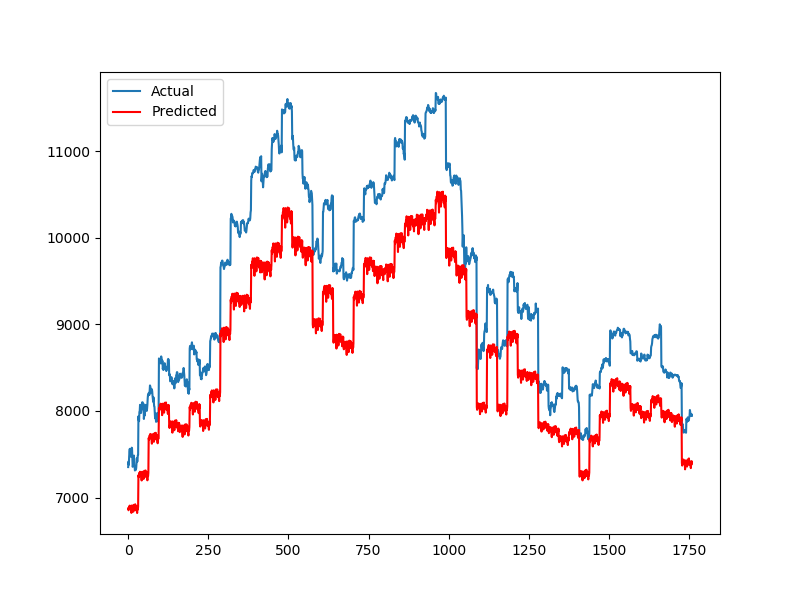

In [28]:
predict = predicted.reshape(-1,1)
truth = validation_labels[0:len(validation_labels):NPS,:].reshape(-1,1)

predict = scaler2.inverse_transform(predict)
truth = scaler2.inverse_transform(truth)

plt.figure(figsize=(8,6))
plt.plot(truth, label = 'Actual')
plt.plot(predict, 'r', label='Predicted')
plt.legend(loc='upper left')
plt.show()

In [43]:
score = model.evaluate(validation_datas,validation_labels,batch_size=32,verbose=1)

16142/16142 [==============================] - 8s 482us/step


In [44]:
print(score)

0.002749334807991933
